# Mean Encoding for Categorical Features

Based on evaluating two potential approaches for implementing mean encoding functionality in our preprocessing pipeline, the preferred approach is creating a separate `MeanEncoder` class rather than integrating it directly into the existing `PreProcessor` class. This decision aligns with the Single Responsibility Principle and mirrors our current architecture, where numeric and categorical transformations are handled as distinct operations. A separate `MeanEncoder` class will not only be easier to test, maintain, and extend, but will also provide the flexibility to implement advanced features such as cross-validation folds and smoothing parameters. While this approach requires managing an additional class and its interactions, the benefits of improved modularity, reusability, and cleaner code organization outweigh these minor drawbacks.

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# MeanEncoder Class

# Mean Encoding for Categorical Features

## Approach Evaluation

### 1. Using Existing Package (sklearn)
* **Benefits**:
    * No additional dependencies (sklearn is a standard ML requirement)
    * Proven, tested implementation
    * Community support and maintenance
    * Time-saving for basic functionality
    * Potential to contribute improvements:
        * Can benefit wider community
        * Learn from expert code reviews
        * Leverage existing test infrastructure
    * Future maintenance handled by community

### 2. Building from Scratch
* **Benefits**:
    * Complete control over implementation
    * Can perfectly match specific requirements
    * Better understanding of the codebase
    * Easier to extend with custom functionality
* **Drawbacks**:
    * More time to implement
    * Need to write own tests
    * Need to handle edge cases
    * Risk of introducing bugs

## Decision
For this repository, we will incorporate sklearn's TargetEncoder into our PreProcessor class because:
1. Avoids additional dependencies
2. Leverages well-tested implementation
3. Aligns with existing sklearn-based architecture

# Incorporating into PreProcessor

Incorporating sklearn `TargetEncoder` into `PreProcessor` 

In [3]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer for data preprocessing.
    
    - Scales numeric features
    - Encodes categorical features
    - Handles missing values via imputation
    - Compatible with scikit-learn pipeline
    
    Attributes:
        num_impute_strategy (str): Numeric imputation strategy
        cat_impute_strategy (str): Categorical imputation strategy
        num_transformer (Pipeline): Numeric preprocessing pipeline
        cat_transformer (Pipeline): Categorical preprocessing pipeline
        target_encoder (TargetEncoder): Sklearn target encoder for mean encoding
        transformed_cat_cols (List[str]): One-hot encoded column names
        num_features (List[str]): Numeric feature names
        cat_features (List[str]): Categorical feature names
        target_encode_cols (List[str]): Columns for target encoding
        target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding
    """

    def __init__(self, num_impute_strategy='median', 
                 cat_impute_strategy='most_frequent',
                 target_encode_cols=None,
                 target_encode_smooth='auto'):
        """
        Initialize the transformer.
        
        - Sets up numeric data transformer
        - Sets up categorical data transformer
        - Configures imputation strategies

        
        Parameters:
            num_impute_strategy (str): Strategy for numeric missing values
            cat_impute_strategy (str): Strategy for categorical missing values
            target_encode_cols (List[str]): Columns to apply mean encoding
            target_encode_smooth (Union[str, float]): Smoothing parameter for target encoding,
                                                      'auto' or float value (default='auto')
        """
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy
        self.target_encode_cols = target_encode_cols
        self.target_encode_smooth = target_encode_smooth

    def fit(self, X, y=None):
        """
        Fit transformer on input data.
        
        - Identifies feature types
        - Configures feature scaling
        - Sets up encoding
        - Fits imputation strategies
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            CustomTransformer: Fitted transformer
        """
        if self.target_encode_cols and y is None:
            raise ValueError("Target variable y is required when target_encode_cols is specified")
        
        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = [col for col in X.select_dtypes(exclude=np.number).columns 
                             if col not in (self.target_encode_cols or [])]
        
        if self.target_encode_cols:
            missing_cols = [col for col in self.target_encode_cols if col not in X.columns]
            if missing_cols:
                raise ValueError(f"Columns {missing_cols} not found in input data")
        
        # Handle mean encoding features
        if self.target_encode_cols:
            self.target_encoder = TargetEncoder(
                smooth=self.target_encode_smooth,
                cv=5
            )
            mean_encode_features = [f for f in self.target_encode_cols if f in X.columns]
            if mean_encode_features:
                self.target_encoder.fit(X[mean_encode_features], y)

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy)),
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Get transformed categorical column names.
        
        - Creates names after one-hot encoding
        - Combines category with encoded values
        
        Returns:
            List[str]: One-hot encoded column names
        """
        if not hasattr(self, 'cat_transformer'):
            return []
        
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transform input data.
        
        - Applies fitted scaling
        - Applies fitted encoding
        - Handles numeric and categorical features
        
        Parameters:
            X (pd.DataFrame): Input features
        
        Returns:
            pd.DataFrame: Transformed data
        """
        if not hasattr(self, 'num_features'):
            raise ValueError("Transformer not fitted. Call 'fit' before 'transform'.")
        
        X_transformed = pd.DataFrame()

        if self.target_encode_cols and hasattr(self, 'target_encoder'):
            mean_encoded_features = self.target_encoder.transform(X[self.target_encode_cols])
            mean_encoded_df = pd.DataFrame(
                mean_encoded_features, 
                columns=self.target_encode_cols,
            )
            X_transformed = pd.concat([X_transformed, mean_encoded_df], axis=1)

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols)
            X_transformed = pd.concat([X_transformed, transformed_cat_df], axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fit and transform input data.
        
        - Fits transformer to data
        - Applies transformation
        - Combines both operations
        
        Parameters:
            X (pd.DataFrame): Input features
            y (pd.Series, optional): Target variable, not used
        
        Returns:
            pd.DataFrame: Transformed data
        """
        self.fit(X, y)
        return self.transform(X)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(10, 1, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features for one-hot encoding
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
    'occupation': np.random.choice(['Engineer', 'Doctor', 'Teacher', 'Other'], n_samples),
    
    # Categorical features for target encoding (with varying frequencies)
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*100 + ['D']*30 + ['E']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Initialize and fit PreProcessor
preprocessor = PreProcessor(
    num_impute_strategy='median',
    cat_impute_strategy='most_frequent',
    target_encode_cols=['city', 'product'],  # Specify columns for target encoding
    # target_encode_smooth = 'auto',
    target_encode_smooth = 10
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Print results
print("Original data shape:", data.shape)
print("\nProcessed train data shape:", X_train_processed.shape)
print("\nProcessed test data shape:", X_test_processed.shape)

print("\nOriginal category frequencies in 'city':")
print(data['city'].value_counts())

print("\nOriginal total category means in 'city':")
print(target.groupby(data['city']).agg(['count', 'mean']))

print("\nOriginal train category means in 'city':")
print(target.groupby(X_train['city']).agg(['count', 'mean']))

# Compare with original values (using index from X_train_processed)
comparison = pd.DataFrame({
    'Original_City': X_train.loc[X_train_processed.index, 'city'],
    'Encoded_City': X_train_processed['city'],
    # 'Target': y_train.loc[X_train_processed.index]
}).drop_duplicates()

print("\nComparison of original vs encoded values:")
print(comparison)

# Optional: Show encoding statistics by category
print("\nEncoding statistics by category:")
encoding_stats = pd.DataFrame({
    'train_Mean': y_train.groupby(X_train['city']).mean(),
    'Encoded_Mean_train': X_train_processed.groupby(X_train['city'])['city'].mean(),
    'Encoded_Mean_new': X_test_processed.groupby(X_test['city'])['city'].mean()
})
print(encoding_stats)

Original data shape: (1000, 7)

Processed train data shape: (800, 13)

Processed test data shape: (200, 13)

Original category frequencies in 'city':
city
NYC        497
LA         292
Chicago    134
Miami       31
Seattle     26
Name: count, dtype: int64

Original total category means in 'city':
         count      mean
city                    
Chicago    134  0.582090
LA         292  0.633562
Miami       31  0.580645
NYC        497  0.730382
Seattle     26  0.538462

Original train category means in 'city':
         count      mean
city                    
Chicago    102  0.568627
LA         228  0.618421
Miami       25  0.640000
NYC        405  0.735802
Seattle     21  0.476190

Comparison of original vs encoded values:
    Original_City  Encoded_City
29          Miami      0.647500
535           NYC      0.734127
695       Chicago      0.577344
836            LA      0.620431
165           NaN      0.574569
9         Seattle      0.537500

Encoding statistics by category:
         

<Figure size 1200x600 with 0 Axes>

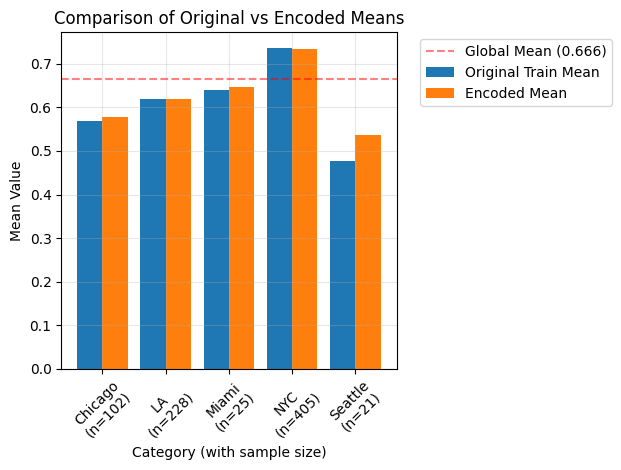

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate means and create comparison DataFrame
results = pd.DataFrame({
    # 'Total Category Mean': target.groupby(data['city']).mean(),
    'Original Train Mean': y_train.groupby(X_train['city']).mean(),
    'Encoded Mean': X_train_processed.groupby(X_train['city'])['city'].mean()
})

# Add sample sizes for reference
category_sizes = X_train['city'].value_counts().sort_index()
global_mean = y_train.mean()

# Create bar plot
plt.figure(figsize=(12, 6))
results.plot(kind='bar', width=0.8)

# Add horizontal line for global mean
plt.axhline(y=global_mean, color='r', linestyle='--', alpha=0.5, 
            label=f'Global Mean ({global_mean:.3f})')

plt.title('Comparison of Original vs Encoded Means')
plt.xlabel('Category (with sample size)')
plt.ylabel('Mean Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add sample sizes to x-labels
plt.xticks(range(len(category_sizes)), 
           [f'{cat}\n(n={size})' for cat, size in category_sizes.items()], 
           rotation=45)

plt.tight_layout()
plt.show()

## Doublecheck result consistency with TargetEncoder


Results with smooth=auto:
         Sample_Size  Original_Mean  Encoded_Mean  Global_Mean
city                                                          
Chicago          102       0.568627      0.564109      0.66625
LA               228       0.618421      0.619292      0.66625
Miami             25       0.640000      0.667166      0.66625
NYC              405       0.735802      0.736370      0.66625
Seattle           21       0.476190      0.492852      0.66625

Results with smooth=10.0:
         Sample_Size  Original_Mean  Encoded_Mean  Global_Mean
city                                                          
Chicago          102       0.568627      0.578737      0.66625
LA               228       0.618421      0.620874      0.66625
Miami             25       0.640000      0.635544      0.66625
NYC              405       0.735802      0.733974      0.66625
Seattle           21       0.476190      0.545634      0.66625


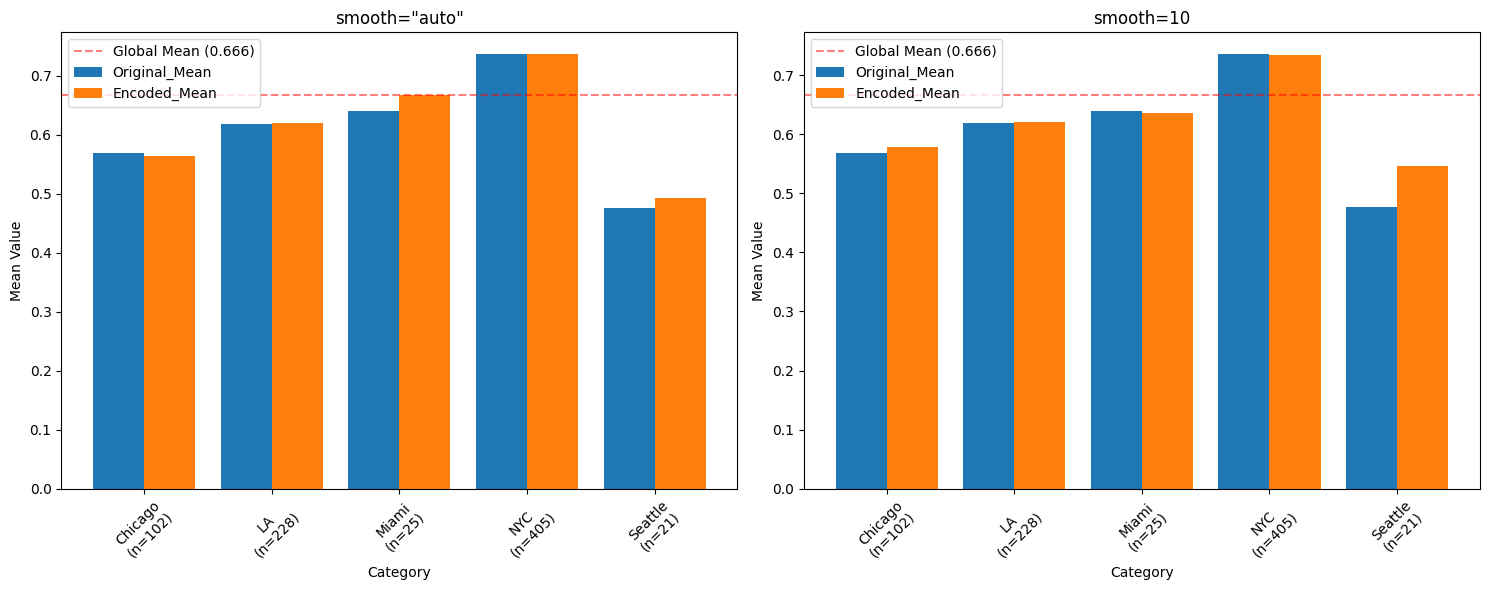


Actual smoothing value used with smooth='auto':


In [5]:
# Test different smoothing parameters
def compare_smoothing(X_train, y_train, smooth_param):
    # Initialize encoder
    encoder = TargetEncoder(smooth=smooth_param, cv=5)
    encoded = encoder.fit_transform(X_train[['city']], y_train)
    
    # Calculate means
    results = pd.DataFrame({
        'Sample_Size': X_train['city'].value_counts(),
        'Original_Mean': y_train.groupby(X_train['city']).mean(),
        'Encoded_Mean': pd.DataFrame(encoded, columns=['city'], index=X_train.index)
                          .groupby(X_train['city'])['city'].mean(),
    })
    results['Global_Mean'] = y_train.mean()
    
    print(f"\nResults with smooth={smooth_param}:")
    print(results)
    return results

# Compare auto vs explicit smoothing
results_auto = compare_smoothing(X_train, y_train, 'auto')
results_10 = compare_smoothing(X_train, y_train, 10.0)

# Create a single figure for both plots
plt.figure(figsize=(15, 6))

# Get sample sizes
category_sizes = X_train['city'].value_counts().sort_index()

# Plot for smooth='auto'
plt.subplot(1, 2, 1)
results_auto[['Original_Mean', 'Encoded_Mean']].plot(kind='bar', width=0.8, ax=plt.gca())
plt.axhline(y=results_auto['Global_Mean'].iloc[0], color='r', linestyle='--', alpha=0.5,
            label=f'Global Mean ({results_auto["Global_Mean"].iloc[0]:.3f})')
plt.title('smooth="auto"')
plt.xlabel('Category')
plt.ylabel('Mean Value')
# Add sample sizes to x-labels
plt.xticks(range(len(category_sizes)), 
           [f'{cat}\n(n={size})' for cat, size in category_sizes.items()], 
           rotation=45)
plt.legend()

# Plot for smooth=10
plt.subplot(1, 2, 2)
results_10[['Original_Mean', 'Encoded_Mean']].plot(kind='bar', width=0.8, ax=plt.gca())
plt.axhline(y=results_10['Global_Mean'].iloc[0], color='r', linestyle='--', alpha=0.5,
            label=f'Global Mean ({results_10["Global_Mean"].iloc[0]:.3f})')
plt.title('smooth=10')
plt.xlabel('Category')
plt.ylabel('Mean Value')
# Add sample sizes to x-labels
plt.xticks(range(len(category_sizes)), 
           [f'{cat}\n(n={size})' for cat, size in category_sizes.items()], 
           rotation=45)
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print the actual smoothing value used
encoder = TargetEncoder(smooth='auto')
encoder.fit(X_train[['city']], y_train)
print("\nActual smoothing value used with smooth='auto':")
# print(encoder.smooth)